/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8904 - loss: 0.3556 - precision: 0.9005 - recall: 0.8755

Test Results:
Loss: 0.3762
Accuracy: 0.8894
Weighted Precision: 0.8981
Weighted Recall: 0.8768

Class labels:
0 = glioma_tumor
1 = meningioma_tumor
2 = no_tumor
3 = pituitary_tumor
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Class-wise Metrics:
           Class  Precision   Recall  F1 Score
    glioma_tumor   0.917127 0.897297  0.907104
meningioma_tumor   0.863388 0.840426  0.851752
        no_tumor   0.878378 0.812500  0.844156
 pituitary_tumor   0.892308 0.966667  0.928000


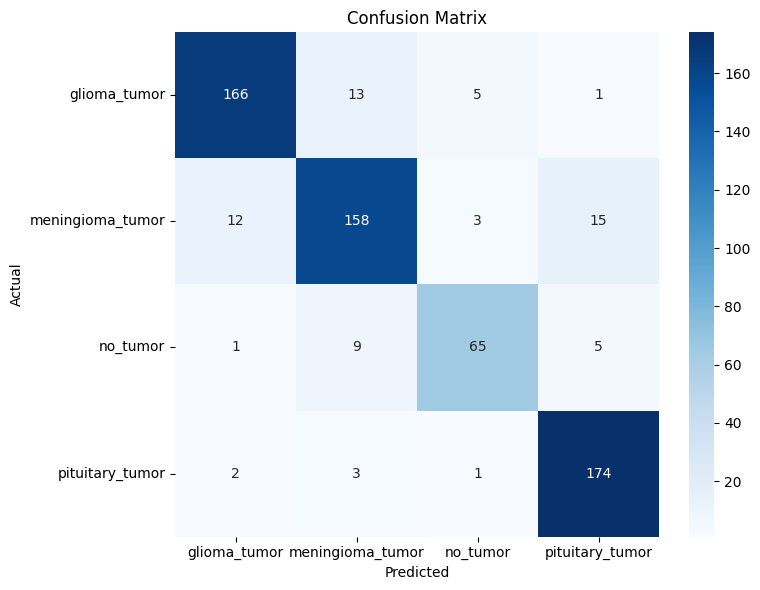

In [1]:
# - Data Augmentation


import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def load_images_from_folder(folder_path, img_size=128):
    X = []
    y = []
    labels = [label for label in sorted(os.listdir(folder_path)) if os.path.isdir(os.path.join(folder_path, label))]
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_folder = os.path.join(folder_path, label)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(label_map[label])
            except:
                continue

    X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0
    y = to_categorical(np.array(y), num_classes=len(label_map))
    return X, y, label_map

data_path = "Tumor"
X, y, label_map = load_images_from_folder(data_path)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

results = model.evaluate(X_test, y_test)
print(f"\nTest Results:")
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"Weighted Precision: {results[2]:.4f}")
print(f"Weighted Recall: {results[3]:.4f}")

print("\nClass labels:")
for label, idx in sorted(label_map.items(), key=lambda x: x[1]):
    print(f"{idx} = {label}")

# Confusion Matrix and Class-wise Metrics
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

precision_per_class = precision_score(y_true, y_pred_classes, average=None)
recall_per_class = recall_score(y_true, y_pred_classes, average=None)
f1_per_class = f1_score(y_true, y_pred_classes, average=None)

metrics_df = pd.DataFrame({
    'Class': list(label_map.keys()),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})
print("\nClass-wise Metrics:")
print(metrics_df.to_string(index=False))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()